In [18]:
import sys
sys.path.append('../')
import deepst.dataloader as dataloader
import deepst.model as model
import numpy as np
import torch
import h5py
from torch.utils import data

In [2]:
print(torch.cuda.is_available())

False


In [3]:
c,p,t,y,d=dataloader.get_all_data()

c:\users\hu\miniconda3\envs\pytorch11\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


4800 4800
(6, 32, 32)
3792 3792 3792 3792 4800
4368 4368
(6, 32, 32)
3360 3360 3360 3360 4368
5472 5472
(6, 32, 32)
4464 4464 4464 4464 5472


In [4]:
c.dtype

dtype('float64')

In [5]:
y_max=y.max()
y_min=y.min()
print(y_max,y_min)

1270.0 0.0


In [6]:
f=dataloader.get_feature_data(d)
print(len(f))

Temperature (59006,) float64
Weather (59006, 17) float64
WindSpeed (59006,) float64
date (59006,) |S10
11616


In [7]:
def minmax(data):
    data=1.*(data-0)/(1270-0)
    data=data*2.0-1.0
    return data
def rescale(data,max=1270.0,min=0.0):
    data=(data+1.)/2.
    data=1.*data*(max-min)+min
    return data

In [8]:
from torch.utils import data
class TaxiBJ(data.Dataset):
    def __init__(self):
        pass
    def __getitem__(self,index):
        return minmax(c[index]),minmax(p[index]),minmax(t[index]),f[index],minmax(y[index])
    
    def __len__(self):
        return len(c)

In [9]:
dataset=TaxiBJ()

In [10]:
loader=data.DataLoader(dataset=dataset,batch_size=1000,shuffle = False)

In [12]:
ct,pt,tt,ft,yt=dataset[1]

In [13]:
device=torch.device('cpu')

In [14]:
class ToTensor(object):
    def __call__(self,c,p,t,f,y):
        ct=torch.from_numpy(c).unsqueeze(0)
        pt=torch.from_numpy(p).unsqueeze(0)
        tt=torch.from_numpy(t).unsqueeze(0)
        ft=torch.from_numpy(f).unsqueeze(0)
        yt=torch.from_numpy(y).unsqueeze(0)
        return ct.to(device),pt.to(device),tt.to(device),ft.to(device),yt.to(device)

In [15]:
trans=ToTensor()

In [19]:
net=model.ResNet()
net.double()

ResNet(
  (close): resunit(
    (unit): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): residual(
        (left): Sequential(
          (0): ReLU(inplace)
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (2): residual(
        (left): Sequential(
          (0): ReLU(inplace)
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (3): residual(
        (left): Sequential(
          (0): ReLU(inplace)
          (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (4): ReLU(inplace)
      (5): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (period): resunit(
    (unit): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): residual(
        (left): 

In [20]:
from tensorboardX import SummaryWriter
with SummaryWriter(comment='ST-ResNet')as w:
    w.add_graph(net, (ct,pt,tt,ft))

ModuleNotFoundError: No module named 'tensorboardX'

In [21]:
import torch.optim as optim
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [22]:
crit=torch.nn.MSELoss()

In [12]:
import time
thistime=time.strftime('%Y-%m-%d-%H-%M',time.localtime())
txtname=thistime+'.txt'

'2019-05-07-15-51.txt'

In [23]:
ff=open(txtname,'w')

In [24]:
for i in range(15500):
    for step in enumerate(loader):
        ct,pt,tt,ft,yt=dataset[i]
        ct,pt,tt,ft,yt=trans(ct,pt,tt,ft,yt)
        optimizer.zero_grad()
        out=net(ct,pt,tt,ft)
        loss=crit(out,yt)
        loss.backward()
        optimizer.step()
        #ff.write(str(loss.item())+'\n')
        print(loss.item())
ff.close()

0.5665296336837746
0.23886900813108305
0.09793685538488234
0.2897375730939964
0.41639897060346287
0.2608713208379602
0.09705622101953668
0.13655870987276952
0.25134488238015684
0.2539405599764943
0.15098763092130238
0.08186084836316107
0.11095976966991147
0.17167835850398225
0.16449273506143136
0.10461407077865441
0.0712997834378916
0.09118167041762854
0.12178215784811992
0.11990555558122834
0.08996557023989524
0.06718698301728582
0.07169367878791862
0.08932010790970925


KeyboardInterrupt: 

In [16]:
torch.save(net.state_dict(), 'params_6_14_all_scale.pkl')

In [17]:
Y=[]
f=open('train_6_14.txt','r')

In [18]:
for line in f.readlines():
    #print(line.strip())
    Y.append(float(line.strip()))

In [19]:
import matplotlib.pyplot as plt
x=range(len(Y))

In [20]:
plt.bar(x,Y)


<Container object of 15500 artists>

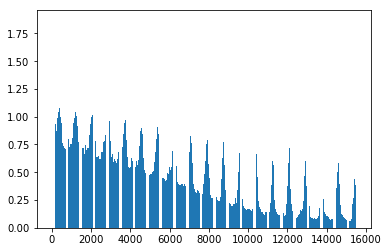

In [21]:
plt.show()

In [22]:
f.close()